In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
RAW_interactions = pd.read_csv('data/RAW_interactions.csv')
RAW_recipes = pd.read_csv('data/RAW_recipes.csv')
RAW_interactions.head(5)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [3]:
print(f"Nombre d'utilisateurs: {len(RAW_interactions.user_id.unique())}")
print(f"Nombre de recettes: {len(RAW_interactions.recipe_id.unique())}")

Nombre d'utilisateurs: 226570
Nombre de recettes: 231637


## NCF

In [4]:
from tqdm import tqdm
import torch
import torch.nn as nn
from statistics import mean
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# #Creating a train and a test set
testset = RAW_interactions.sample(frac=0.1, replace=False)
trainset = RAW_interactions[~RAW_interactions.index.isin(testset.index)]

# assert set(testset.user_id.unique()).issubset(trainset.user_id.unique())
# assert set(testset.recipe_id.unique()).issubset(trainset.recipe_id.unique())

AssertionError: 

In [5]:
user_list = list(trainset.user_id.unique()) + list(testset.user_id.unique())
item_list = list(trainset.recipe_id.unique()) + list(testset.recipe_id.unique())
user2id = {w: i for i, w in enumerate(user_list)} # {user1: 0, user2: 1, ...}
item2id = {w: i for i, w in enumerate(item_list)} # {item1: 0, item2: 1, ...}

class Ratings_Dataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index()

    def __len__(self):
        return len(self.df)
  
    def __getitem__(self, idx):
        user = user2id[self.df['user_id'][idx]]
        user = torch.tensor(user, dtype=torch.long)
        item = item2id[self.df['recipe_id'][idx]]
        item = torch.tensor(item, dtype=torch.long)
        rating = torch.tensor(self.df['rating'][idx], dtype=torch.float)
            
        return user, item, rating


trainloader = DataLoader(Ratings_Dataset(trainset), batch_size=512, shuffle=True ,num_workers=2)
testloader = DataLoader(Ratings_Dataset(testset), batch_size=64, num_workers=2)

### Entrainement du NCF

In [6]:
def train(model, optimizer, trainloader, epochs=30):
    criterion = nn.MSELoss(reduction='mean')
    t = tqdm(range(epochs))
    for epoch in t:
        corrects = 0
        total = 0
        train_loss = []
        for users, items, r in trainloader:
            users = users.to(device)
            items = items.to(device)
            r = r.to(device) / 5  # normalize ratings to [0, 1]
            y_hat = model(users, items)
            loss = criterion(y_hat, r.unsqueeze(1).float())
            train_loss.append(loss.item())
            total += r.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f"loss: {mean(train_loss):.4f}")
            
            
class NCF(nn.Module):

    def __init__(self, n_users, n_items, n_factors=12):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.user_embeddings = torch.nn.Embedding(n_users, n_factors)
        self.item_embeddings = torch.nn.Embedding(n_items, n_factors)
        self.predictor = torch.nn.Sequential(
            nn.Linear(in_features=n_factors*2, out_features=64),
            nn.Linear(in_features=64, out_features=32),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )
        
        
    def forward(self, user, item):
        u = self.user_embeddings(user)
        i = self.item_embeddings(item)

        # Concat the two embedding layers
        z = torch.cat([u, i], dim=-1)
        return self.predictor(z)

In [8]:
n_user = len(user_list)
n_items = len(item_list)
model = NCF(n_user, n_items).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=5)

loss: 0.0533: 100%|██████████| 5/5 [10:29<00:00, 125.99s/it]


### Test du NCF

In [9]:
import math

def test(model, testloader):

    running_mae = 0
    with torch.no_grad():
        corrects = 0
        total = 0
        for users, items, r in testloader:
            users = users.to(device)
            items = items.to(device)
            y = r.to(device) / 5
            y_hat = model(users, items).flatten()
            error = torch.abs(y_hat - y).sum().data
        
            running_mae += error
            total += y.size(0)
            
    
    mae = running_mae/total
    return mae * 5
    

print(f"MAE sur les données de test: {test(model, testloader):.3f}")

MAE sur les données de test: 0.763


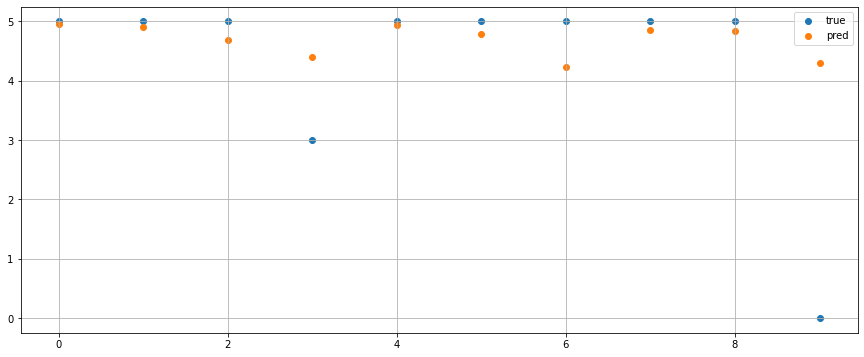

In [10]:
users, recipes, r = next(iter(testloader))
users = users.to(device)
recipes = recipes.to(device)
r = r.to(device)

y = model(users, recipes)*5

plt.figure(figsize=(15,6))
plt.scatter(range(10), r[:10].data)
plt.scatter(range(10), y.flatten()[:10].data)
plt.legend(["true", "pred"])
plt.grid();

## Sauvegarde des variables

### Sauvegarde des poids du modèle

In [11]:
torch.save(model.state_dict(), 'weights.pth')

### Sauvegarde des mappings `user2id` et `item2id`

In [12]:
import pickle
pickle.dump([user2id, item2id], open('mapping.pkl', 'wb'))

In [ ]:
# Ecriture du fichier de test
# testset.drop(columns=["rating"]).sample(10).to_csv("test_script.csv", index=False)